In [4]:
import numpy as np
import pandas as pd

confidence_level = 0.05  

# Load cleaned bank stock data
file_path = "C:/Users/manos/OneDrive/Desktop/GitHub/Portfolio1/Project_2_Netherlands_Banking_Risk/cleaned_banks_stock_data.csv"
bank_data = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")

# Compute log returns
returns = np.log(bank_data.pct_change() + 1).dropna()

# Compute Historical VaR (5th percentile return)
VaR_historical = returns.quantile(confidence_level)

# Display results
print("Historical VaR (95% confidence level)")
print(VaR_historical)


Historical VaR (95% confidence level)
NN Group        -0.030370
ING Group       -0.038758
ABN AMRO        -0.028774
KBC Group       -0.027968
Deutsche Bank   -0.022337
Name: 0.05, dtype: float64


In [5]:
from scipy.stats import norm

# Compute mean & standard deviation of returns
mean_returns = returns.mean()
std_returns = returns.std()

# Compute Z-score for 95% confidence level
z_score = norm.ppf(confidence_level)

# Compute Parametric VaR
VaR_parametric = mean_returns + z_score * std_returns

# Display results
print("Parametric VaR (95% confidence, Normal Dist.)")
print(VaR_parametric)


Parametric VaR (95% confidence, Normal Dist.)
NN Group        -0.035157
ING Group       -0.040949
ABN AMRO        -0.033910
KBC Group       -0.032273
Deutsche Bank   -0.027059
dtype: float64


In [6]:
# Define number of simulations
n_simulations = 10000
time_horizon = 1  # 1-day ahead risk

# Generate random normal returns for each bank
simulated_returns = np.random.normal(mean_returns, std_returns, (n_simulations, len(returns.columns)))

# Compute Monte Carlo VaR (5th percentile of simulated returns)
VaR_montecarlo = np.percentile(simulated_returns, confidence_level * 100, axis=0)

# Convert to DataFrame
VaR_montecarlo_df = pd.Series(VaR_montecarlo, index=returns.columns)

# Display results
print("Monte Carlo VaR (95% confidence)")
print(VaR_montecarlo_df)


Monte Carlo VaR (95% confidence)
NN Group        -0.035620
ING Group       -0.040647
ABN AMRO        -0.033957
KBC Group       -0.031835
Deutsche Bank   -0.026846
dtype: float64


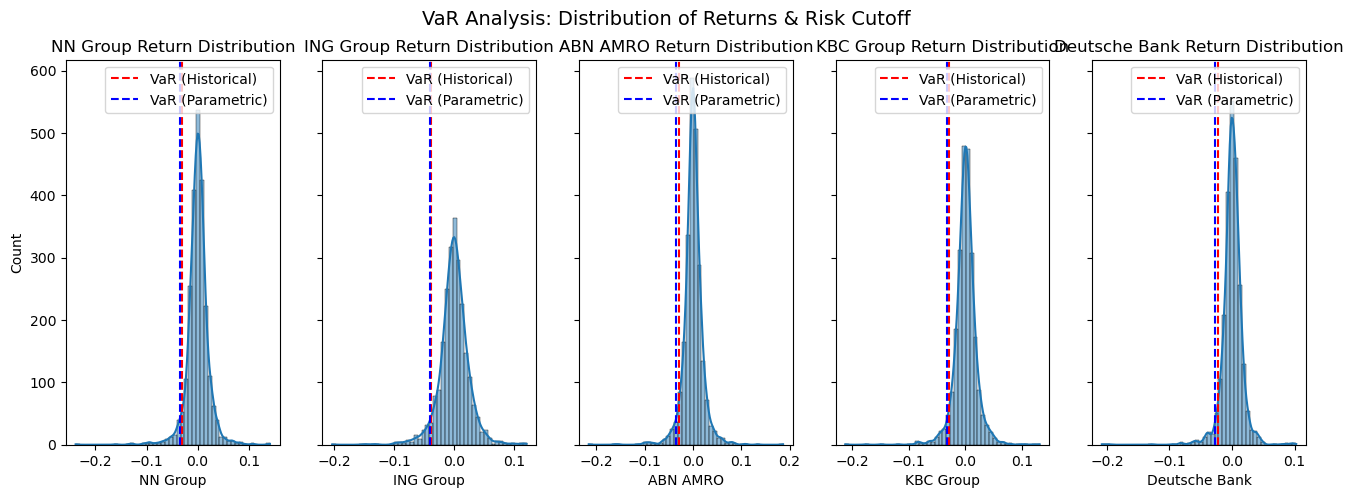

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot return distributions & VaR cutoffs
fig, axes = plt.subplots(1, len(returns.columns), figsize=(16, 5), sharey=True)

for i, bank in enumerate(returns.columns):
    sns.histplot(returns[bank], bins=50, kde=True, ax=axes[i])
    axes[i].axvline(x=VaR_historical[bank], color='red', linestyle='--', label=f'VaR (Historical)')
    axes[i].axvline(x=VaR_parametric[bank], color='blue', linestyle='--', label=f'VaR (Parametric)')
    axes[i].set_title(f"{bank} Return Distribution")
    axes[i].legend()

plt.suptitle("VaR Analysis: Distribution of Returns & Risk Cutoff", fontsize=14)
plt.show()


In [8]:
# Compute Historical Expected Shortfall
def expected_shortfall_historical(returns, confidence_level=0.05):
    var_threshold = returns.quantile(confidence_level)
    return returns[returns <= var_threshold].mean()

ES_historical = returns.apply(lambda x: expected_shortfall_historical(x, confidence_level))

# Compute Parametric Expected Shortfall (Assuming Normal Distribution)
mean_returns = returns.mean()
std_returns = returns.std()
z_score = norm.ppf(confidence_level)
ES_parametric = mean_returns - (std_returns * norm.pdf(z_score) / confidence_level)

# Monte Carlo Expected Shortfall
n_simulations = 10000
simulated_returns = np.random.normal(mean_returns, std_returns, (n_simulations, len(returns.columns)))
ES_montecarlo = np.mean(simulated_returns[simulated_returns <= np.percentile(simulated_returns, confidence_level * 100, axis=0)], axis=0)
ES_montecarlo_df = pd.Series(ES_montecarlo, index=returns.columns)

# Display Results
ES_results = pd.DataFrame({
    "Historical ES": ES_historical,
    "Parametric ES": ES_parametric,
    "Monte Carlo ES": ES_montecarlo_df
})

print("Expected Shortfall (95% confidence level):")
print(ES_results)


Expected Shortfall (95% confidence level):
               Historical ES  Parametric ES  Monte Carlo ES
NN Group           -0.053849      -0.044149       -0.042241
ING Group          -0.061125      -0.051351       -0.042241
ABN AMRO           -0.050360      -0.042612       -0.042241
KBC Group          -0.048281      -0.040560       -0.042241
Deutsche Bank      -0.041060      -0.034028       -0.042241


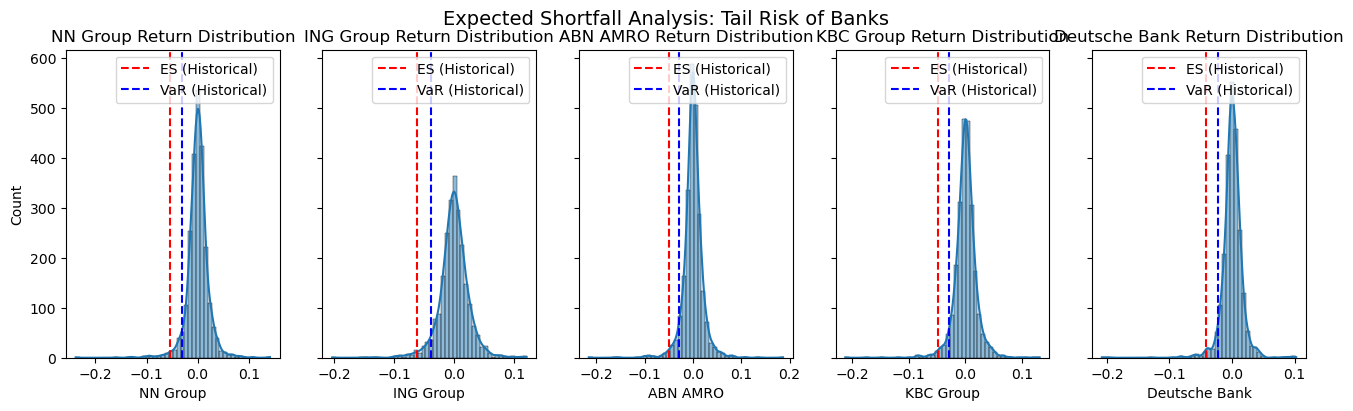

In [10]:
# Plot ES distribution with VaR cutoffs
fig, axes = plt.subplots(1, 5, figsize=(16, 4), sharey=True)

for i, bank in enumerate(returns.columns):
    sns.histplot(returns[bank], bins=50, kde=True, ax=axes[i])
    axes[i].axvline(x=ES_historical[bank], color='red', linestyle='--', label='ES (Historical)')
    axes[i].axvline(x=VaR_historical[bank], color='blue', linestyle='--', label='VaR (Historical)')
    axes[i].set_title(f"{bank} Return Distribution")
    axes[i].legend()

plt.suptitle("Expected Shortfall Analysis: Tail Risk of Banks", fontsize=14)
plt.show()


In [12]:
# Define COVID-19 crisis period
covid_start = "2020-02-15"
covid_end = "2020-04-30"

# Extract data for this period
covid_returns = returns.loc[covid_start:covid_end]

# Compute drawdown (percentage decline from peak)
rolling_max = covid_returns.cumsum().max()
drawdowns = covid_returns.cumsum() - rolling_max

# Compute volatility during crisis
covid_volatility = covid_returns.rolling(window=10).std()

# Compute VaR and ES during this period
VaR_covid = covid_returns.quantile(0.05)
ES_covid = covid_returns[covid_returns <= VaR_covid].mean()

# Display results
stress_results = pd.DataFrame({
    "VaR (COVID-19)": VaR_covid,
    "ES (COVID-19)": ES_covid,
    "Max Drawdown": drawdowns.min(),
    "Volatility Spike": covid_volatility.max()
})
print("COVID-19 Stress Test Results:")
print(stress_results)


COVID-19 Stress Test Results:
               VaR (COVID-19)  ES (COVID-19)  Max Drawdown  Volatility Spike
NN Group            -0.094550      -0.168397     -0.858345          0.100450
ING Group           -0.083557      -0.149193     -0.739481          0.087550
ABN AMRO            -0.096391      -0.156529     -0.914685          0.111193
KBC Group           -0.091286      -0.162020     -0.657510          0.103905
Deutsche Bank       -0.084661      -0.140645     -0.621716          0.087785


<Figure size 1200x600 with 0 Axes>

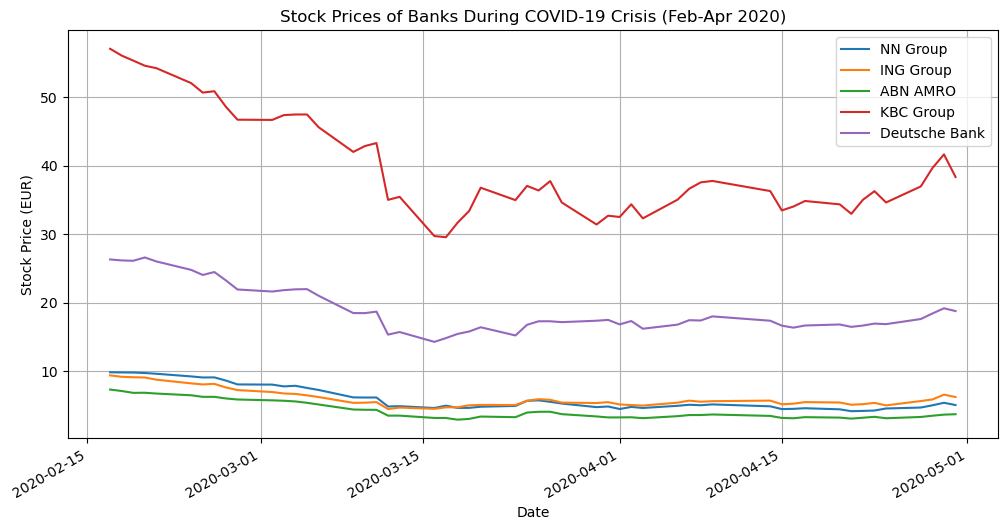

<Figure size 1200x600 with 0 Axes>

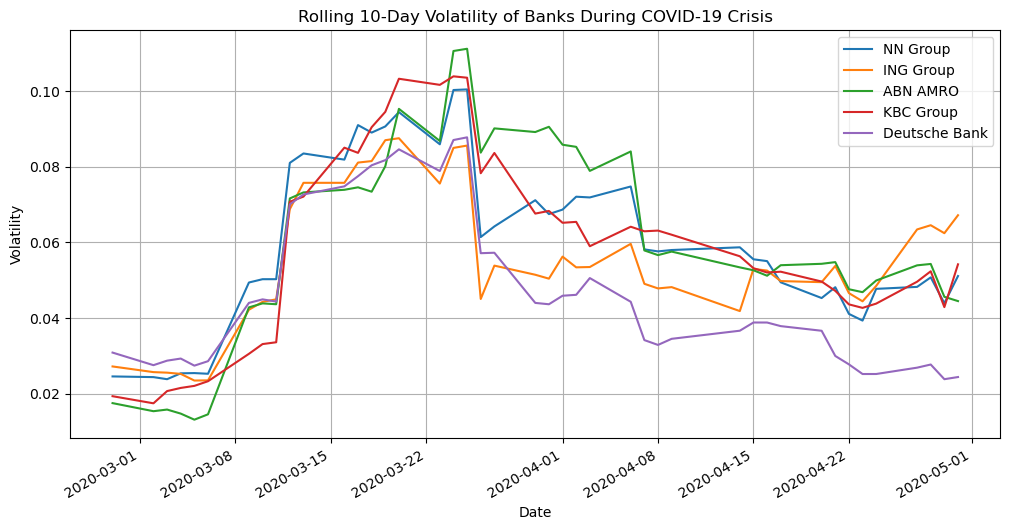

<Figure size 1200x600 with 0 Axes>

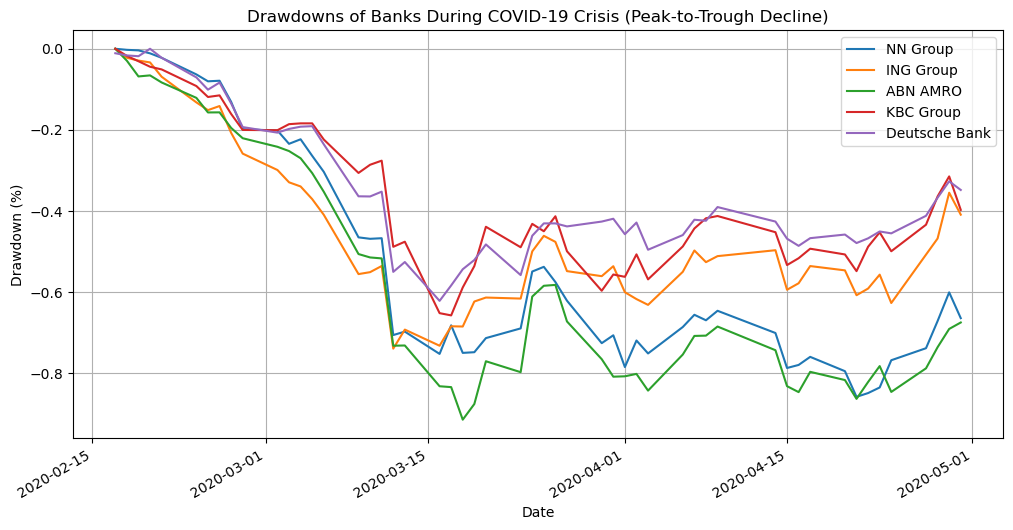

In [13]:
# Plot Stock Prices During COVID-19
plt.figure(figsize=(12,6))
bank_data.loc[covid_start:covid_end].plot(figsize=(12,6))
plt.title("Stock Prices of Banks During COVID-19 Crisis (Feb-Apr 2020)")
plt.ylabel("Stock Price (EUR)")
plt.xlabel("Date")
plt.grid()
plt.legend()
plt.show()

# Plot Rolling 10-Day Volatility Increase
plt.figure(figsize=(12,6))
covid_volatility.plot(figsize=(12,6))
plt.title("Rolling 10-Day Volatility of Banks During COVID-19 Crisis")
plt.ylabel("Volatility")
plt.xlabel("Date")
plt.grid()
plt.legend()
plt.show()

# Plot Drawdowns
plt.figure(figsize=(12,6))
drawdowns.plot(figsize=(12,6))
plt.title("Drawdowns of Banks During COVID-19 Crisis (Peak-to-Trough Decline)")
plt.ylabel("Drawdown (%)")
plt.xlabel("Date")
plt.grid()
plt.legend()
plt.show()

